In [1]:
%matplotlib nbagg
import os
#from time import sleep
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import qcodes as qc
import math as math
from qcodes import (
    Measurement,
    experiments,
    initialise_database,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_experiment,
    load_last_experiment,
    load_or_create_experiment,
    new_experiment,
)
from qcodes.dataset.plotting import plot_dataset
from qcodes.logger.logger import start_all_logging
import qcodes.instrument_drivers.tektronix.Keithley_6500
import qcodes_contrib_drivers.drivers.QuTech.IVVI
import zhinst.qcodes


print ("Done")

Done


In [2]:
start_all_logging()
station = qc.Station() # we will load all instruments
print ("Done")

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\Lab\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\Lab\.qcodes\logs\211013-20740-qcodes.log
Done


In [3]:
k1= qc.instrument_drivers.tektronix.Keithley_6500.Keithley_6500('k1','TCPIP::192.168.0.101::INSTR', reset_device=False)
k2= qc.instrument_drivers.tektronix.Keithley_6500.Keithley_6500('k2','TCPIP::192.168.0.102::INSTR', reset_device=False)

station.add_component(k1)# we will load all instruments
station.add_component(k2)# we will load all instruments

iv1 = qcodes_contrib_drivers.drivers.QuTech.IVVI.IVVI('iv1', 'ASRL5::INSTR') # we will load all instruments: IVVI rack
station.add_component(iv1)

lockin=zhinst.qcodes.MFLI("lockin", "dev4956", interface="pcie", host="192.168.0.110", port=8004) # load the lockin
station.add_component(lockin)

print ("Done")

Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04456734, firmware:1.0.04b) in 0.04s
Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04456732, firmware:1.0.04b) in 0.03s
Initialized IVVI-rack in 0.03s
Successfully connected to data server at 192.168.0.110:8004 api version: 6
Successfully connected to device DEV4956 on interface PCIE
Connected to: Zurich Instruments MFLI (serial:dev4956, firmware:65939) in 0.48s


2021-10-13 13:45:43,212 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 214 ¦ [lockin_demods1(ZINode)] Snapshot: Could not update parameter: sample
2021-10-13 13:45:46,220 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 214 ¦ [lockin_demods2(ZINode)] Snapshot: Could not update parameter: adcselect
2021-10-13 13:46:01,842 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 214 ¦ [lockin_demods2(ZINode)] Snapshot: Could not update parameter: sample
2021-10-13 13:46:04,848 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 214 ¦ [lockin_demods3(ZINode)] Snapshot: Could not update parameter: adcselect
2021-10-13 13:46:20,470 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 214 ¦ [lockin_demods3(ZINode)] Snapshot: Could not update parameter: sample
2021-10-13 13:46:23,476 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 214 ¦ [lockin_extrefs0(ZINode)] Snapshot: Could not update parameter: enable
2021-10-13 13:46:24,765 ¦ qcodes.

Done


In [4]:
#test of lockin functionalities
# complex signal X,Y or R,phi
print(np.real(lockin.demods[0].sample()))  # test whether the lockin does what it should
print(np.imag(lockin.demods[0].sample()))
print(np.abs(lockin.demods[0].sample()))
print(np.angle(lockin.demods[0].sample(),deg=True))
# oscillator frequency
print(lockin.oscs.oscs0.freq())
# time constant
print(lockin.demods[0].timeconstant())
# output amplitude
print(lockin.sigouts.amplitudes0()[0])

-0.00048710788779415435
7.2052539158645615e-06
0.0004871526036942448
179.14713860129223
71.13000002334502
0.30004751682281494
0.7071075439453125


In [5]:
#example for setting lockin parameters
lockin.sigouts.amplitudes0(2e-3)

In [6]:
# safety for IVVI rack: everything is set to zero Volt before attaching a device.
# !! WARNING !! #
# do not unground your sample before setting this !!

iv1.set_dacs_zero()

print ("Done")

Done


In [8]:
number = 0

In [52]:
# Pinch off traces with bottomgate at fixed bias 2021-10-05 
# dac4 is set for applying voltages to the bottom gate 

number += 1

datafile_path = 'datafile'+str(datetime.date.today())+'pinch off pinBG_36_'+str(number)+'.txt'
BIAS = 1000   # DC bias, mV
amp = 5     # Gate voltage amplification
freq = 73.24 # lockin frequency, Hz
tc = 0.3   # lockin time constant, s
l_amp = np.sqrt(2)*500e-3 # lockin output amplitude, V
wait_time = 2 #waiting time for each datapoint, s


#set DC bias
iv1.dac1(BIAS)
time.sleep(5)

#lockin settings
#set the frequency
lockin.oscs.oscs0.freq(freq)
#set the time constant
lockin.demods[0].timeconstant(tc)
#set the output amplitude
lockin.sigouts.amplitudes0(l_amp)
#turn lockin output on
lockin.sigouts[0].on(1)
time.sleep(5)

#gate range and step size (all in mV)
gatestep=int(round(20/amp))
startGATE=int(round(-3500/amp))
endGATE=int(round(3500/amp))


#gently ramp gate to starting point
if startGATE>amp*int(round(iv1.dac_voltages()[4-1])):
    for g in range (int(amp*round(iv1.dac_voltages()[4-1])),startGATE+gatestep,gatestep):
        iv1.dac4(g) #This should set the gate voltage
        time.sleep(0.2)
elif startGATE<amp*int(round(iv1.dac_voltages()[4-1])):
    for g in range (int(round(iv1.dac_voltages()[4-1])),startGATE-gatestep,-gatestep):
        iv1.dac4(g) #This should set the gate voltage
        time.sleep(0.2)
elif startGATE==amp*int(round(iv1.dac_voltages()[4-1])):
        iv1.dac4(startGATE) #This should set the gate voltage
        g=startGATE
        time.sleep(0.2)
else:
        iv1.dac4(0)
print('BottomGate ramped to start ',amp*g,' mV')
time.sleep(10* wait_time)

#write datafile header

with open(datafile_path, 'w+') as f:
    header = "Start time is "+datetime.datetime.now().strftime("%X")+"\n"
    np.savetxt(f, [], header=header)
    
    #define the header string
    header_top = "GATEvoltage, BIASvoltage, Current, Real-LI, Imag-LI"+"\n"
    header_units = "mV, mV, nA, V, V" + "\n"
    header_comments = "Comments: bias = 1mV; lockin freq = 73.24; lockin V = 500mV-Rms, tau = 300ms, 1MV/A" + "\n" #you can use this to log some of the settings you use
    header = header_top + header_units + header_comments
    np.savetxt(f, [], header=header)
    f.flush()

#main cycle
        
for x in range (startGATE,endGATE+gatestep,+gatestep): # This sets a range for the sweep
    iv1.dac4(x)
    time.sleep(wait_time)                                           # Measurement timescale
    
    #Log all the measured values
    gates1      = amp*iv1.dac_voltages()[4-1]        # Due to the amp (if used) the real value is 5x the set value
    voltages1   = iv1.dac_voltages()[1-1]
    currents1   = (-1)*k2.amplitude()                # This records the current using the current to voltage measurement (IN MICROAMPS!!!)
    lockin1_val = lockin.demods[0].sample()
    reallockin1 = np.real(lockin1_val)
    imaglockin1 = np.imag(lockin1_val)
    
    #save the data
    data        = np.column_stack((gates1,voltages1,currents1,reallockin1,imaglockin1)) 
    with open(datafile_path, 'a+') as f:
        np.savetxt(f, data, fmt=['%.7f','%.7f','%.7f','%.15f','%.15f'])
        f.flush()

#write end of the datafile
             
with open(datafile_path, 'a+') as f:
    header = "End time is "+datetime.datetime.now().strftime("%X")+"\n"
    np.savetxt(f, [], header=header)
    f.flush()
    
iv1.dac1(0) # bias to zero
lockin.sigouts[0].on(0) # turn off lockin output    


BottomGate ramped to start  -3500  mV


In [15]:
freq_swept = np.logspace(1, 3, num=21)
print (freq_swept)
tc = 10/freq_swept 
print (tc)
number = 0

[  10.           12.58925412   15.84893192   19.95262315   25.11886432
   31.6227766    39.81071706   50.11872336   63.09573445   79.43282347
  100.          125.89254118  158.48931925  199.5262315   251.18864315
  316.22776602  398.10717055  501.18723363  630.95734448  794.32823472
 1000.        ]
[1.         0.79432823 0.63095734 0.50118723 0.39810717 0.31622777
 0.25118864 0.19952623 0.15848932 0.12589254 0.1        0.07943282
 0.06309573 0.05011872 0.03981072 0.03162278 0.02511886 0.01995262
 0.01584893 0.01258925 0.01      ]


In [19]:
# Pinch off traces with bottomgate at fixed bias 2021-10-05 
# dac4 is set for applying voltages to the bottom gate 

number += 1

datafile_path = 'datafile'+str(datetime.date.today())+'freq_sweep_'+str(number)+'.txt'
BIAS = 0   # DC bias, mV
amp = 5     # Gate voltage amplification
freq = 73.24 # lockin frequency, Hz
tc = 0.3   # lockin time constant, s
l_amp = np.sqrt(2)*500e-3 # lockin output amplitude, V
wait_time = 2 #waiting time for each datapoint, s


####  Freq sweep calc
freq_swept = np.logspace(1, 3, num=201)
#tc = 10/freq_swept 



#####


#lockin settings
#set the frequency
lockin.oscs.oscs0.freq(freq)
#set the time constant
lockin.demods[0].timeconstant(tc)
#set the output amplitude
lockin.sigouts.amplitudes0(l_amp)
#turn lockin output on
lockin.sigouts[0].on(1)
time.sleep(1)



#write datafile header

with open(datafile_path, 'w+') as f:
    header = "Start time is "+datetime.datetime.now().strftime("%X")+"\n"
    np.savetxt(f, [], header=header)
    
    #define the header string
    header_top = "Freq , Real-LI, Imag-LI, Phase-deg"+"\n"
    header_units = "Hz,V, V,deg" + "\n"
    header_comments = "Comments: " + "\n" #you can use this to log some of the settings you use
    header = header_top + header_units + header_comments
    np.savetxt(f, [], header=header)
    f.flush()

#main cycle
        
for x in freq_swept: # This sets a range for the sweep
    
    #set the frequency
    lockin.oscs.oscs0.freq(x)          
    
    time.sleep(wait_time)                                           # Measurement timescale
    
    #Log all the measured values
    
    lockin1_val = lockin.demods[0].sample()
    reallockin1 = np.real(lockin1_val)
    imaglockin1 = np.imag(lockin1_val)
    deg = np.angle(lockin1_val,deg =True)
          
    
    
    #save the data
    data        = np.column_stack((x,reallockin1,imaglockin1,deg)) 
    with open(datafile_path, 'a+') as f:
        np.savetxt(f, data, fmt=['%.4f','%.15f','%.15f','%.5f'])
        f.flush()

#write end of the datafile
             
with open(datafile_path, 'a+') as f:
    header = "End time is "+datetime.datetime.now().strftime("%X")+"\n"
    np.savetxt(f, [], header=header)
    f.flush()
    
iv1.dac1(0) # bias to zero
lockin.sigouts[0].on(0) # turn off lockin output    


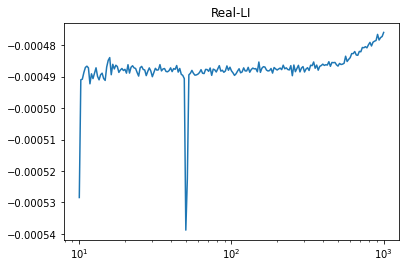

In [30]:
%matplotlib inline
freq = np.loadtxt("datafile2021-10-13freq_sweep_4.txt")[:, 0]
real = np.loadtxt("datafile2021-10-13freq_sweep_4.txt")[:, 1]
im = np.loadtxt("datafile2021-10-13freq_sweep_4.txt")[:, 2]

phase = np.loadtxt("datafile2021-10-13freq_sweep_4.txt")[:, 3]

plt.figure()
plt.plot(freq,real)
plt.title('Real-LI')
plt.xscale('log')
plt.show()


#print(a)

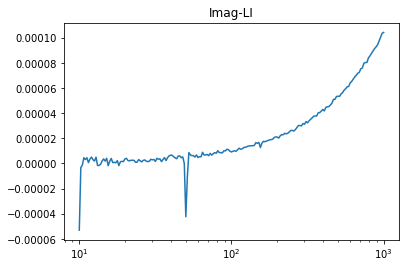

In [33]:
plt.figure()
plt.plot(freq,im)
plt.title('Imag-LI')
plt.xscale('log')
plt.show()

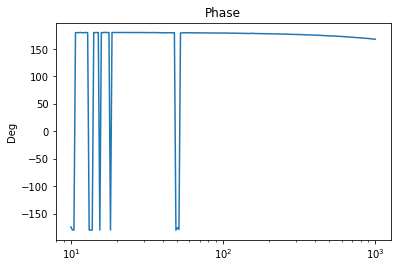

In [34]:
plt.figure()
plt.plot(freq,phase)
plt.title('Phase')
plt.ylabel('Deg')
plt.xscale('log')
plt.show()

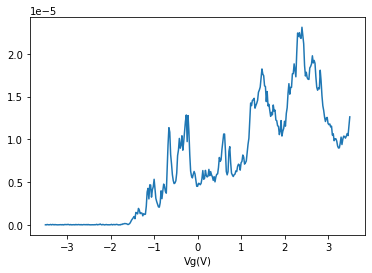

In [55]:
#### Gate voltage measurements
%matplotlib inline
Vg = np.loadtxt("datafile2021-10-13pinch off pinBG_36_5.txt")[:, 0]
vout = np.loadtxt("datafile2021-10-13pinch off pinBG_36_5.txt")[:, 3]

plt.figure()
plt.plot(Vg*1e-3,abs(vout)/5)
plt.xlabel('Vg(V)')
plt.show()



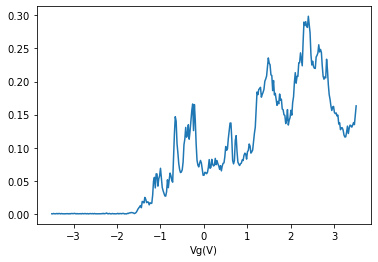

In [56]:
#### Gate voltage measurements
%matplotlib inline
h = 6.62*1e-34
e = 1.6 *1e-19

vout = abs(vout)/5

G = vout/((2*e**2)/h) # Conductance

plt.figure()
plt.plot(Vg*1e-3,G)
plt.xlabel('Vg(V)')
plt.show()


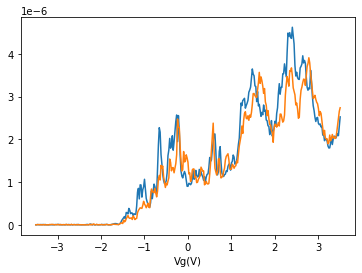

In [51]:
### Compare the two

#### Gate voltage measurements
%matplotlib inline
Vg_1 = np.loadtxt("datafile2021-10-13pinch off pinBG_36_6.txt")[:, 0]
vout_1 = np.loadtxt("datafile2021-10-13pinch off pinBG_36_6.txt")[:, 3]
vout_1 = abs(vout_1)/5
plt.figure()
plt.plot(Vg*1e-3,abs(vout)/5)
plt.plot(Vg_1*1e-3,abs(vout_1)/5)
plt.xlabel('Vg(V)')
plt.show()


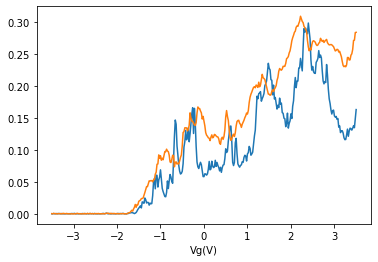

In [57]:
#### Gate voltage measurements
%matplotlib inline
Vg_HighBias = np.loadtxt("datafile2021-10-13pinch off pinBG_36_7.txt")[:, 0]
vout_HighBias = np.loadtxt("datafile2021-10-13pinch off pinBG_36_7.txt")[:, 3]
vout_HighBias = abs(vout_HighBias)/5
G1 = vout_HighBias/((2*e**2)/h) # Conductance

plt.figure()
plt.plot(Vg*1e-3,G,label='0mw bIAS')
plt.plot(Vg_HighBias*1e-3,G1)
plt.xlabel('Vg(V)')
plt.show()
